In [1]:
!pip install git+https://github.com/bxt-kk/vikit-learn.git

  Cloning https://github.com/bxt-kk/vikit-learn.git to /tmp/pip-req-build-ppk1z9g4
  Running command git clone --filter=blob:none --quiet https://github.com/bxt-kk/vikit-learn.git /tmp/pip-req-build-ppk1z9g4
  Resolved https://github.com/bxt-kk/vikit-learn.git to commit bef5a9320558027067d4f658e7812485844800f2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 27.1 MB/s eta 0:00:00
  Created wheel for vikit-learn: filename=vikit_learn-0.0.1-py3-none-any.whl size=37690 sha256=91cdb11e6809f0ba1ffdf61b29c1112736ab8fd5ffa4e271a087c478669e6807
  Stored in directory: /tmp/pip-ephem-wheel-cache-ksi4id_v/wheels/ba/a5/2b/6c981b4fb807523a31b616b17bfbc3360ead4e0a33b95179da
Successfully built vikit-learn


In [2]:
!mkdir /kaggle/working/OxfordIIITPet
!ln -sv \
 /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations \
 /kaggle/working/OxfordIIITPet/
!ln -sv \
 /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images \
 /kaggle/working/OxfordIIITPet/

'/kaggle/working/OxfordIIITPet/annotations' -> '/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations'
'/kaggle/working/OxfordIIITPet/images' -> '/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images'


In [3]:
import torch
torch.manual_seed(3)
from torch.utils.data import DataLoader

from vklearn.trainer.trainer import Trainer
from vklearn.trainer.tasks import Detection
from vklearn.models.trimnetdet import TrimNetDet as Model
from vklearn.datasets.oxford_iiit_pet import OxfordIIITPet

In [4]:
dataset_root = '/kaggle/working/OxfordIIITPet'
dataset_type = 'detection'

train_transforms, test_transforms = Model.get_transforms()

train_data = OxfordIIITPet(
    dataset_root,
    split='trainval',
    target_types=dataset_type,
    transforms=train_transforms)
test_data = OxfordIIITPet(
    dataset_root,
    split='trainval',
    target_types=dataset_type,
    transforms=test_transforms)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(categories=train_data.bin_classes)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 53.8MB/s]


In [5]:
batch_size = 16

train_loader = DataLoader(
    train_data, batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=model.collate_fn,
    num_workers=4)
test_loader = DataLoader(
    test_data, batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=model.collate_fn,
    num_workers=4)

print(len(train_loader))

229


In [6]:
task = Detection(
    model, device, metric_start_epoch=0, fit_features_start=0,
    loss_options={'weights': dict(conf=1., bbox=1., clss=0.33)},
    # score_options={'conf_thresh': 0.5},
    # metric_options={'conf_thresh': 0.5},
)
trainer = Trainer(
    task,
    output='/kaggle/working/catdog',
    checkpoint=None,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=10,
    lr=1e-3,
    show_step=50,
    save_epoch=5)

trainer.initialize()

Preparing ...
device: cuda
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)
train dataset: Dataset OxfordIIITPet
    Number of datapoints: 3671
    Root location: /kaggle/working/OxfordIIITPet
    Compose(
      ToImage()
      ScaleJitter(target_size=(448, 448), scale_range=(0.9, 1.1), interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=1)
      RandomHorizontalFlip(p=0.5)
      RandomCrop(size=(448, 448), pad_if_needed=True, padding_mode=constant)
      SanitizeBoundingBoxes(min_size=5, labels_getter=default)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
{'batch_size': 16, 'num_workers': 4}
test dataset: Data

--------------------------------------------------------------------------------
Training ...
train mode: True
lr=[0.001]
epoch: 1/10, step: 50/229
{"train": {"loss": 0.8548, "conf_loss": 0.32929, "bbox_loss": 0.40458, "clss_loss": 0.36647, "sampled_loss": 0.13111, "conf_precision": 0.00971, "conf_recall": 0.79875, "conf_f1": 0.01915, "iou_score": 0.60921, "clss_accuracy": 0.8325, "proposals": 117.30875, "obj_conf_min": 0.56428}}
epoch: 1/10, step: 100/229
{"train": {"loss": 0.7394, "conf_loss": 0.28696, "bbox_loss": 0.36031, "clss_loss": 0.27917, "sampled_loss": 0.0955, "conf_precision": 0.0202, "conf_recall": 0.82812, "conf_f1": 0.0391, "iou_score": 0.65115, "clss_accuracy": 0.87625, "proposals": 74.07438, "obj_conf_min": 0.665}}
epoch: 1/10, step: 150/229
{"train": {"loss": 0.67693, "conf_loss": 0.26389, "bbox_loss": 0.33806, "clss_loss": 0.22722, "sampled_loss": 0.07795, "conf_precision": 0.03046, "conf_recall": 0.84458, "conf_f1": 0.05804, "iou_score": 0.67276, "clss_accuracy": 0.

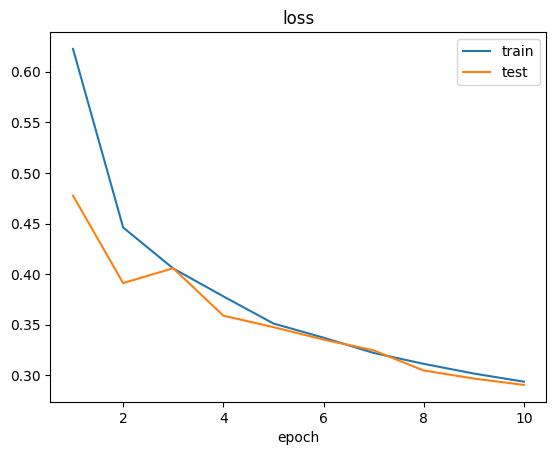

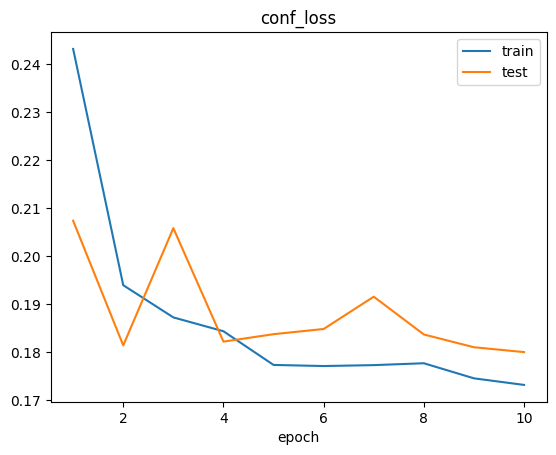

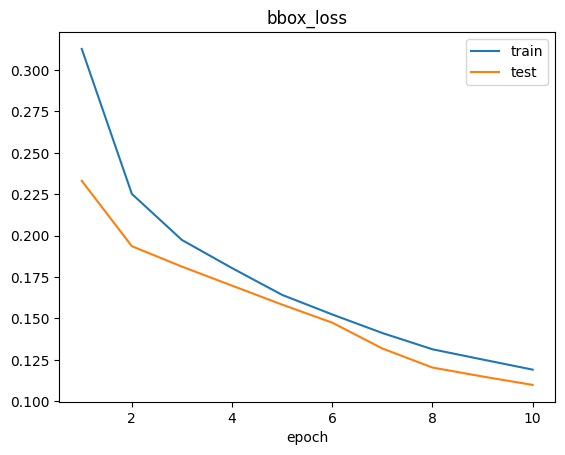

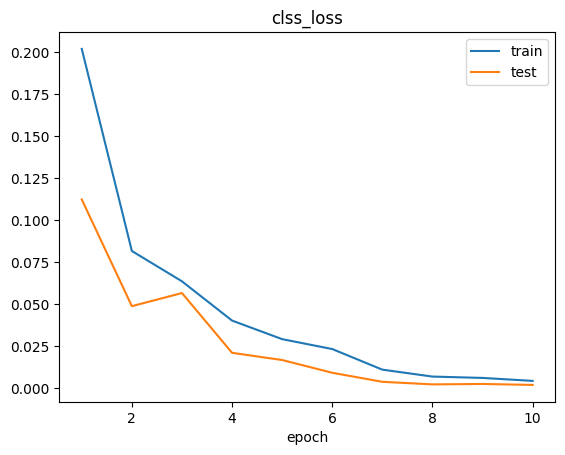

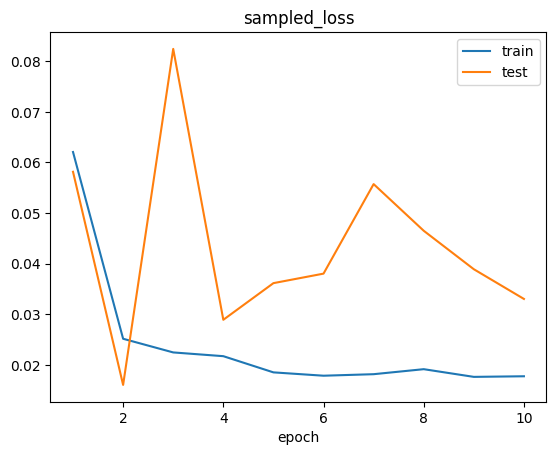

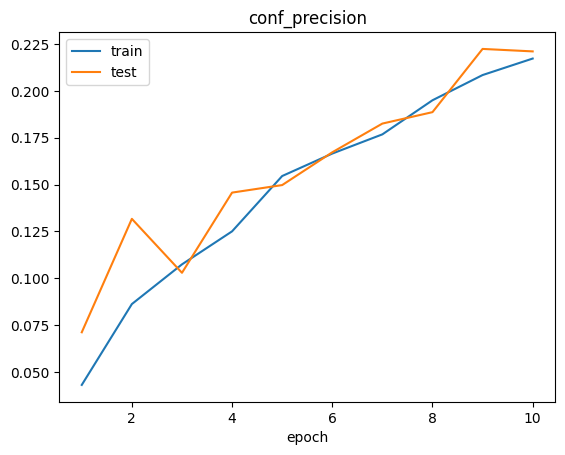

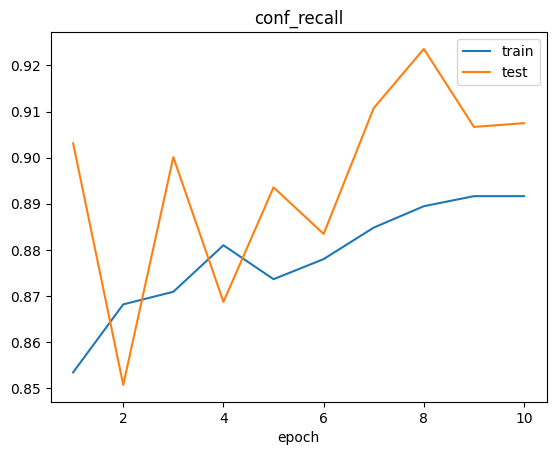

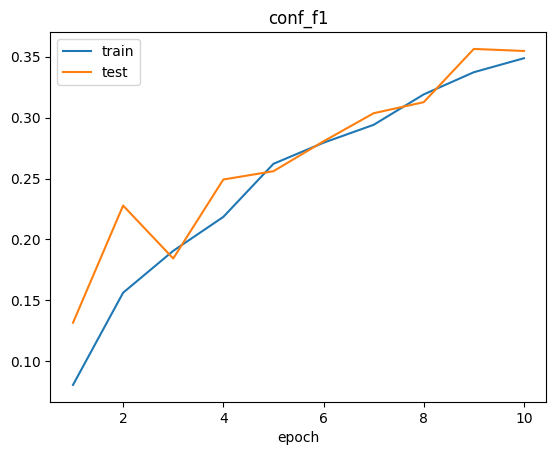

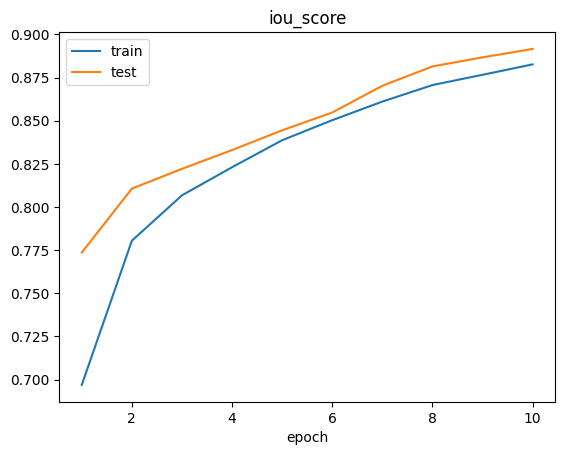

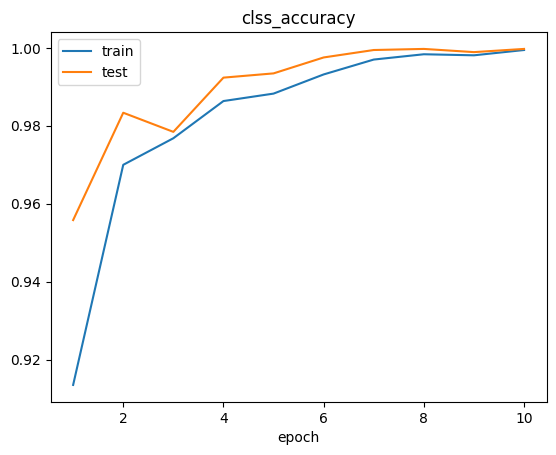

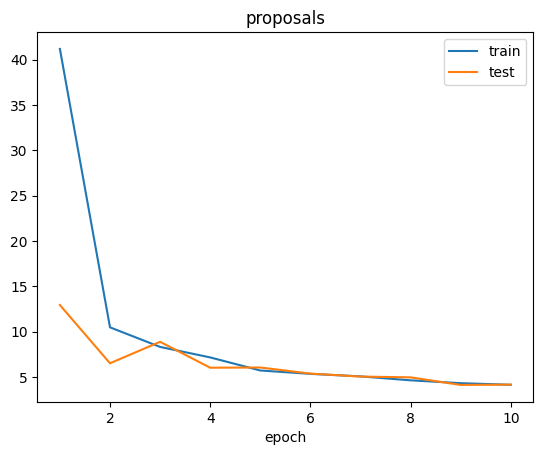

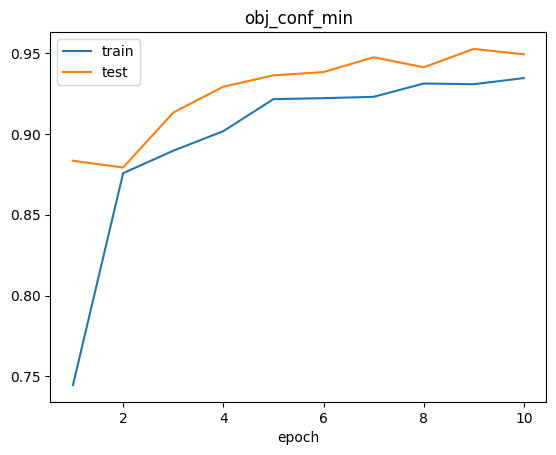

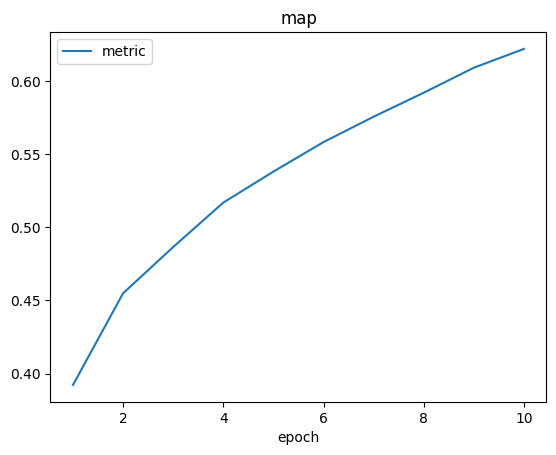

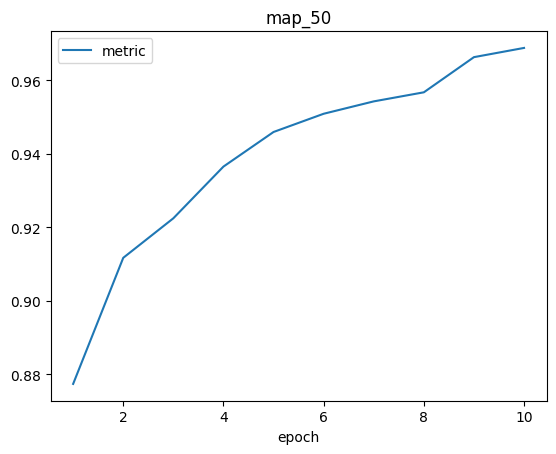

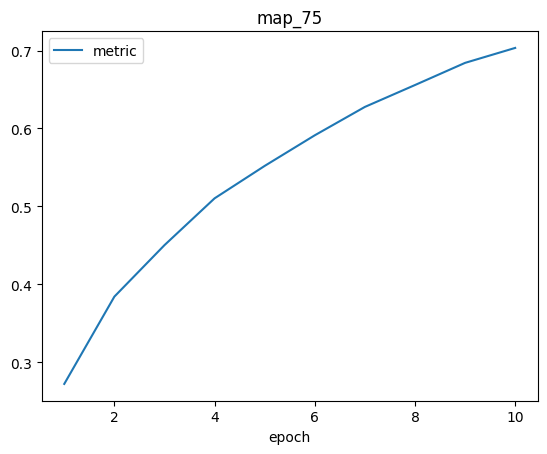

In [7]:
trainer.fit(max_train_step=0, max_test_step=0)